In [ ]:
"""some notes in developing the conv1d layer"""

In [1]:
import numpy as np
from pprint import pprint

In [3]:
def correlate1(X, K):
    """1d correlation"""
    
    xw = len(X)
    kw = len(K)
    ow = xw - kw + 1
    
    if ow >= 1:
        return np.fromiter((np.sum(X[i:i+kw] * K) for i in range(ow)), dtype=float)
    else:
        return correlate1(K, X)

def convolve1(X, K):
    return correlate1(X, np.flip(K))

In [4]:
convolve1(np.array([1,2,3]), np.array([1]))

array([1., 2., 3.])

In [5]:
def correlate2(X, K):
    """handles 1d convolution with height (2d)"""
    
    xw = X.shape[1]
    kw = K.shape[1]
    ow = xw - kw + 1
    
    if ow >= 1:
        return [np.sum(X[:, i:i+kw] * K) for i in range(ow)]
    else:
        return correlate2(K, X)  # correlation is commutative

def convolve2(X, K):
    return correlate2(X, np.flip(K, axis=1))

correlate2(np.array([[1,2,3]]), np.array([[1,0]]))

[1, 2]

In [17]:
def correlate3(XS, KS):
    """handles 1d convolution with batches & multiple kernels (3d)"""
#     print("XS:", XS)
#     print(XS.shape)
#     print("KS:", KS)
#     print(KS.shape)
    xshape = XS.shape
    kshape = KS.shape
    
    assert (len(xshape)==3 and len(kshape)==3), "3d input required"
    assert xshape[1] == kshape[1], "kernels not spanning input height"
    
    return np.array([[correlate2(x, k) for k in KS] for x in XS])

# for loop equivalent:
#     ys = []
#     for x in XS:
#         y = []
#         for k in KS:
#             y.append(convolve2(x, k))
#         ys.append(y)
#    return ys

def convolve3(XS, KS):
    return correlate3(XS, np.flip(KS, axis=1))

In [7]:
correlate3(np.array([[[1,2,3], [0,0,0]], [[-1,-1,-1],[2,3,4]]]), np.array([[[1,0],[0,1]], [[0,0],[0,0]]]))

XS: [[[ 1  2  3]
  [ 0  0  0]]

 [[-1 -1 -1]
  [ 2  3  4]]]
(2, 2, 3)
KS: [[[1 0]
  [0 1]]

 [[0 0]
  [0 0]]]
(2, 2, 2)


array([[[1, 2],
        [0, 0]],

       [[2, 3],
        [0, 0]]])

In [8]:
# flatten layer:
# forward: flatten, save shape
# backward: reshape

# maxpool
# forward: apply max kernel, save position
# backward: pass dout directly to saved position?

In [9]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent = os.path.dirname(os.path.abspath(''))
sys.path.append(parent)

from network.layers.layer import Layer

In [10]:
class Flatten_layer(Layer):
    
    def __init__(self):
        self.type = "flatten"
    
    def forward(self, X, param):
        self.shape = X.shape
        return np.reshape(X, (self.shape[0],-1))
    
    def backward(self, dout, param):
        return dout.reshape(self.shape)

# test

In [11]:
import network

In [12]:
X = np.arange(100).reshape(25, 1, 4)
y = np.sum(X, axis=2)

In [233]:
class Conv1d_layer():
    
    def __init__(self, in_channels, out_channels, kernel_wid, stride=1):
        
        self.type = 'conv1d'
        self.ic = in_channels  # height
        self.oc = out_channels  # number of kernels
        self.kw = kernel_wid  # width
        self.stride = stride
        
        self.kernels = np.random.randn(self.oc, self.ic, self.kw) / np.sqrt(self.oc/2)  # what is the best initialization for kernels?
        # oc is used here since it's analogous to input_nodes in linear layers (i.e., the number of units in a layer)
        
    def forward(self, X, param):
        
        self.inputs = X
        return correlate3(X, self.kernels)
    
    def backward(self, douts, param):
        
        lr = param.get('lr', 1e-5)
        clip = param.get('clip', 1.0)
        
        #print(f"incoming dout: {dout}")
        
        
        # calculate dx to pass to next layer
        dxs = []
        for dy in douts:
            dx = [[convolve1(d, row) for row in k] for d, k in zip(dy, self.kernels)]
            dx = np.sum(np.array(dx), axis=0)
            dxs.append(dx)
        
        # calculate dw to update
        dws = []
        for x, dout in zip(self.inputs, douts):
            for error in dout:  # each error come from one kernel
                dws.append([convolve1(row, error) for row in x])
                
        dws = np.array(dws)
        num = len(self.kernels)  # number of kernels
        
        # sum all dw to each kernel
        dks = []
        for i in range(num):
            dks.append(np.sum(dws[i::num, :, :], axis=0))
        
        # update
        for i in range(num):
            dk = dks[i] * lr
            magnitude = np.linalg.norm(dk)
            if magnitude > clip:
                dk = dk / magnitude * clip
            self.kernels[i] -= dk
        
        return dxs

    def print_parameters(self):
        pprint(vars(self))

In [263]:
nn = network.NeuralNetwork([
                            Conv1d_layer(1, 2, 4),
                            Flatten_layer(),
                            network.Linear_layer(2, 1)
                            ])
param = {"lr": 3e-5, 'batch': 8, "mode": "train", "eps": 1e-9, "beta":(0.9, 0.999), 
         "epoch": 0, 'optimizer': 'Adam', 't': 1, 'clip': 1.0, 'decay': 0.0}

In [264]:
nn.print_parameters()

--0--
{'ic': 1,
 'kernels': array([[[-0.16977704,  0.05058232, -0.07279522,  0.82372131]],

       [[ 0.3268527 ,  0.89538112,  1.73980184,  0.19081756]]]),
 'kw': 4,
 'oc': 2,
 'stride': 1,
 'type': 'conv1d'}
--1--
Printing flatten layer:
{'type': 'flatten'}
--2--
Printing linear layer:
{'bias': 0,
 'input_nodes': 2,
 'm1': array([[0.],
       [0.]]),
 'm2': array([[0.],
       [0.]]),
 'output_nodes': 1,
 'type': 'linear',
 'weights': array([[ 0.10308278],
       [-1.59627314]])}


In [265]:
for _ in range(200):
    nn.train(X, y, param, loss_func='mse')

Average loss = 264254.543972.
Average loss = 258074.008383.
Average loss = 249561.341142.
Average loss = 246268.871193.
Average loss = 240123.635979.
Average loss = 230581.350790.
Average loss = 233587.367978.
Average loss = 227475.004720.
Average loss = 220174.459633.
Average loss = 215923.567425.
Average loss = 211339.501807.
Average loss = 206618.010331.
Average loss = 198591.916620.
Average loss = 197717.440710.
Average loss = 188047.047302.
Average loss = 186929.295350.
Average loss = 181713.461707.
Average loss = 175563.604734.
Average loss = 173063.626607.
Average loss = 167418.346260.
Average loss = 163380.025420.
Average loss = 156899.075359.
Average loss = 155106.187291.
Average loss = 148649.243476.
Average loss = 145349.576825.
Average loss = 142252.744909.
Average loss = 137365.356750.
Average loss = 134010.731401.
Average loss = 128903.991324.
Average loss = 126277.154866.
Average loss = 121123.563712.
Average loss = 118084.409857.
Average loss = 115074.971005.
Average lo

In [266]:
nn.print_parameters()

--0--
{'ic': 1,
 'inputs': array([[[88, 89, 90, 91]],

       [[28, 29, 30, 31]],

       [[80, 81, 82, 83]],

       [[64, 65, 66, 67]],

       [[20, 21, 22, 23]],

       [[68, 69, 70, 71]],

       [[ 4,  5,  6,  7]],

       [[12, 13, 14, 15]]]),
 'kernels': array([[[-0.07766144,  0.1441434 ,  0.02221136,  0.92017338]],

       [[-1.03809431, -0.490981  ,  0.33202462, -1.23837478]]]),
 'kw': 4,
 'oc': 2,
 'stride': 1,
 'type': 'conv1d'}
--1--
Printing flatten layer:
{'shape': (8, 2, 1), 'type': 'flatten'}
--2--
Printing linear layer:
{'bias': 0,
 'input': array([[  91.72918201, -217.85703026],
       [  31.19729648,  -71.73315496],
       [  83.65826394, -198.37384688],
       [  67.5164278 , -159.40748014],
       [  23.12637841,  -52.24997158],
       [  71.55188683, -169.14907182],
       [   6.98454227,  -13.28360484],
       [  15.05546034,  -32.76678821]]),
 'input_nodes': 2,
 'm1': array([[-0.00566196],
       [-0.00111646]]),
 'm2': array([[ 3599.6211919 ],
       [13042.5

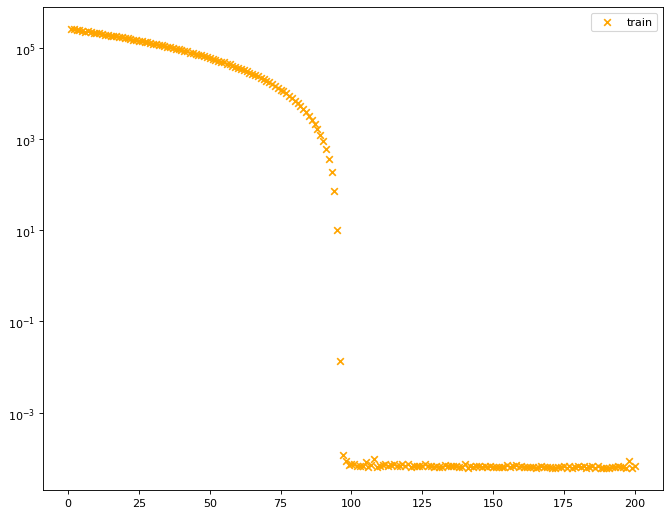

In [267]:
nn.plot_loss()

# dy/dweight

In [2]:
# backprop mathematically:
# note the * means convolve, not multiply

# dOut/dx = dOut/dy * (flip w)
"""The derivative of a convolution is the convolution with its kernel FLIPPED"""

# dOut/dW = dOut/dy * (flip x)

# dOut/db = dOut/dy I guess?

'The derivative of a convolution is the convolution with its kernel FLIPPED'

In [ ]:
# shape = shape of kernels

In [44]:
inputs = np.array([[[1,2,3,4],[1,1,1,1]],[[2,2,3,4],[2,2,2,2]], [[3,2,3,4],[3,3,3,3]]])

In [45]:
douts = np.array([[[1,1],[2,2]], [[-1,-1],[-2,-2]], [[10,10],[20,20]]])

In [55]:
num_kernel = douts.shape[1]

dws = []
for x, dout in zip(inputs, douts):
    for error in dout:  # each dout come from one kernel
        dw = []
        for row in x:
            print(row, error)
            dw.append(convolve1(row, error))
        # partial weight update for one kernel
        
        dws.append(np.array(dw))

[1 2 3 4] [1 1]
[1 1 1 1] [1 1]
[1 2 3 4] [2 2]
[1 1 1 1] [2 2]
[2 2 3 4] [-1 -1]
[2 2 2 2] [-1 -1]
[2 2 3 4] [-2 -2]
[2 2 2 2] [-2 -2]
[3 2 3 4] [10 10]
[3 3 3 3] [10 10]
[3 2 3 4] [20 20]
[3 3 3 3] [20 20]


In [62]:
dws = np.array(dws)
print(dws)
# dw in the form
# dw for k1
# dw for k2
# dw for k1
# ...

[[[  3.   5.   7.]
  [  2.   2.   2.]]

 [[  6.  10.  14.]
  [  4.   4.   4.]]

 [[ -4.  -5.  -7.]
  [ -4.  -4.  -4.]]

 [[ -8. -10. -14.]
  [ -8.  -8.  -8.]]

 [[ 50.  50.  70.]
  [ 60.  60.  60.]]

 [[100. 100. 140.]
  [120. 120. 120.]]]


In [66]:
# sum to each kernel
# dks = 
for i in range(num_kernel):
    print(np.sum(dws[i::num_kernel, :, :], axis=0))

    
# for i in range(len(dks)):
#     self.kernels[i] += dks[i]

[[49. 50. 70.]
 [58. 58. 58.]]
[[ 98. 100. 140.]
 [116. 116. 116.]]


# dy/dx

In [ ]:
# shape = inputs shape

In [107]:
inputs = np.array([[[1,1,1,1],[2,2,2,2]],[[3,3,3,3],[4,4,4,4]]])
print("inputs:", inputs)
kernels = np.array([[[0,1],[1,0]], [[2,2],[2,2]]])
print("kernels:", kernels)
convolve3(inputs, kernels)

inputs: [[[1 1 1 1]
  [2 2 2 2]]

 [[3 3 3 3]
  [4 4 4 4]]]
kernels: [[[0 1]
  [1 0]]

 [[2 2]
  [2 2]]]


array([[[ 3,  3,  3],
        [12, 12, 12]],

       [[ 7,  7,  7],
        [28, 28, 28]]])

In [116]:
douts = np.array([[[1,1,1],[2,2,2]],[[-1,-1,-1],[-2,-2,-2]]])
douts

array([[[ 1,  1,  1],
        [ 2,  2,  2]],

       [[-1, -1, -1],
        [-2, -2, -2]]])

In [138]:
# zero padding
douts = np.pad(douts, 1)[1:-1, 1:-1, :]
douts

array([[[ 0,  1,  1,  1,  0],
        [ 0,  2,  2,  2,  0]],

       [[ 0, -1, -1, -1,  0],
        [ 0, -2, -2, -2,  0]]])

In [156]:
# full loop

dxs = []
for dy in douts:  # -> each y (2d)
    
    x0 = []  # stores partial dx
    for d, k in zip(dy, kernels):  # -> each kernel (2d) and corresponding dy (1d)
        
        x1 = []  # stores rows of the partial dx
        for row in k:  # -> each row in the kernel (1d)
            x1.append(convolve1(d, row))
        
        x0.append(x1)  # concat the rows & add to x0
    
    # sum the result from all kernels
    x0 = np.sum(np.array(x0), axis=0)
    
    dxs.append(x0)
    # jump to next x (dout)

In [157]:
dxs

[array([[4., 9., 9., 5.],
        [5., 9., 9., 4.]]),
 array([[-4., -9., -9., -5.],
        [-5., -9., -9., -4.]])]

In [158]:
dxs = []
for dy in douts:
    dx = [[convolve1(d, row) for row in k] for d, k in zip(dy, kernels)]
    dx = np.sum(np.array(dx), axis=0)
    dxs.append(dx)

In [159]:
dxs

[array([[-4., -9., -9., -5.],
        [-5., -9., -9., -4.]]),
 array([[-4., -9., -9., -5.],
        [-5., -9., -9., -4.]])]

In [160]:
np.array(dxs)

array([[[-4., -9., -9., -5.],
        [-5., -9., -9., -4.]],

       [[-4., -9., -9., -5.],
        [-5., -9., -9., -4.]]])

In [161]:
inputs

array([[[1, 1, 1, 1],
        [2, 2, 2, 2]],

       [[3, 3, 3, 3],
        [4, 4, 4, 4]]])